In [38]:
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
import os

from main import *
from model import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

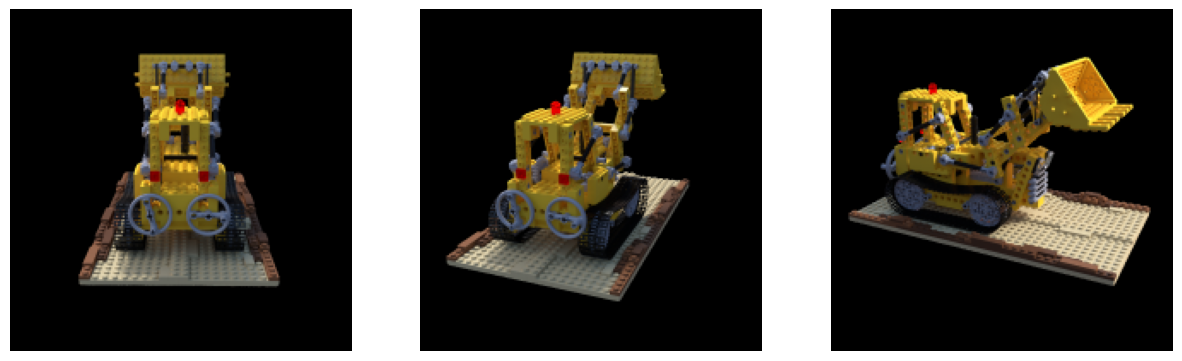

In [3]:
# show 2-3 random images
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].imshow(images_train[i])
    ax[i].axis('off')

In [4]:
batch_size = 10_000
train_dataset = RayDataset(images_train, c2ws_train, focal)
val_dataset = RayDataset(images_val, c2ws_val, focal)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
model = Net3d(device)
print(model)

Net3d(
  (pe_x): PositionalEncoding()
  (pe_rd): PositionalEncoding()
  (mlp1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (mlp2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (density_head): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): ReLU()
  )
  (pre_mix_head): Linear(in_features=256, out_features=256, bias=True)
  (color_head): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)


In [7]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)

In [8]:
loss_list = []
PSNR_list = []

val_loss_list = []
val_PSNR_list = []

def train(model, loss_fn, optimizer):
    
    for i in range(len(train_dataset) // batch_size):
        rays_o, rays_d, rgb_gt = train_dataset.sample_rays(batch_size)
        x = train_dataset.sample_along_rays(rays_o, rays_d) # N x n_samples x 3
        
        optimizer.zero_grad()
        rgb_pred = model(x, rays_d)

        loss = loss_fn(rgb_pred, rgb_gt.to(device))
        loss_list.append(loss.item())
        PSNR_list.append(PSNR(loss).item())

        loss.backward()
        optimizer.step()

        # do validation inference
        if (i + 1) % 25 == 0:
            model.eval()
            with torch.no_grad():
                rays_o, rays_d, rgb_gt = val_dataset.sample_rays(batch_size)
                x = val_dataset.sample_along_rays(rays_o, rays_d)
                rgb_pred = model(x, rays_d)

                val_loss = loss_fn(rgb_pred, rgb_gt.to(device))
                val_loss_list.append(val_loss.item())
                val_PSNR_list.append(PSNR(val_loss).item())

                print(f'Batch {i}, Loss: {loss.item()}, PSNR: {PSNR(loss).item()}, Val Loss: {val_loss.item()}, Val PSNR: {PSNR(val_loss).item()}')
            model.train()

        if i % 10 == 0:
            print(f'Batch {i}, Loss: {loss.item()}, PSNR: {PSNR(loss).item()}')

In [9]:
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(model, loss_fn, optimizer)

Epoch 1
-------------------------------
Batch 0, Loss: 0.08243077993392944, PSNR: 10.839107513427734
Batch 10, Loss: 0.06648199260234833, PSNR: 11.772960662841797
Batch 20, Loss: 0.06342320144176483, PSNR: 11.977519035339355
Batch 24, Loss: 0.061050668358802795, PSNR: 12.143095970153809, Val Loss: 0.05655331909656525, Val PSNR: 12.475419998168945
Batch 30, Loss: 0.0599936842918396, PSNR: 12.218944549560547
Batch 40, Loss: 0.04621601104736328, PSNR: 13.352075576782227
Batch 49, Loss: 0.029042793437838554, PSNR: 15.369616508483887, Val Loss: 0.026186726987361908, Val PSNR: 15.819188117980957
Batch 50, Loss: 0.027124399319291115, PSNR: 15.666399955749512
Batch 60, Loss: 0.023443160578608513, PSNR: 16.29983901977539
Batch 70, Loss: 0.019953561946749687, PSNR: 16.99979591369629
Batch 74, Loss: 0.0194608885794878, PSNR: 17.108373641967773, Val Loss: 0.019788432866334915, Val PSNR: 17.035886764526367
Batch 80, Loss: 0.01955709606409073, PSNR: 17.086956024169922
Batch 90, Loss: 0.0168587900698

Text(0.5, 1.0, 'Val PSNR')

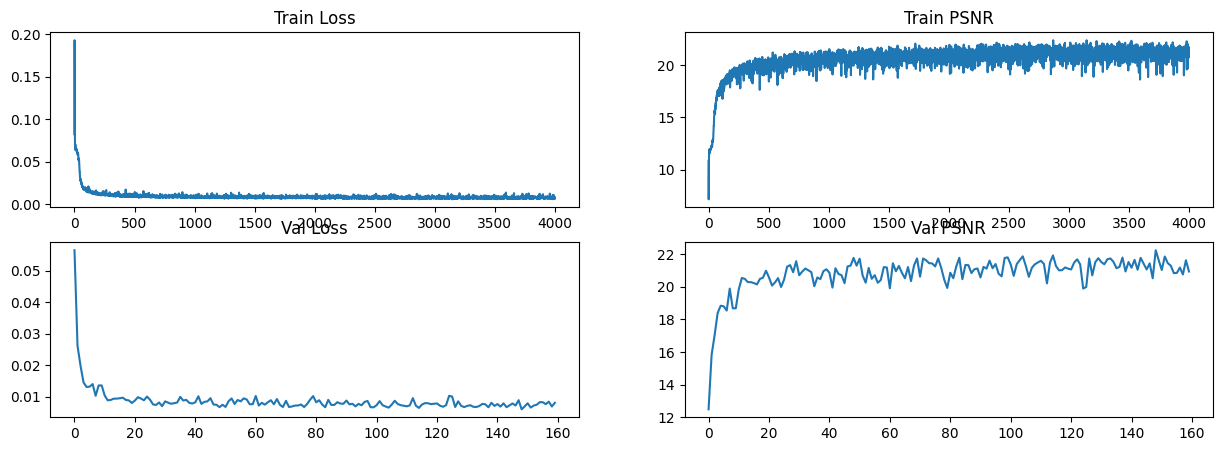

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].plot(loss_list)
ax[0, 0].set_title('Train Loss')

ax[0, 1].plot(PSNR_list)
ax[0, 1].set_title('Train PSNR')

ax[1, 0].plot(val_loss_list)
ax[1, 0].set_title('Val Loss')

ax[1, 1].plot(val_PSNR_list)
ax[1, 1].set_title('Val PSNR')

In [45]:
# get current time for saving model
import datetime
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M")

# create a new folder for the model in the trained_models folder
os.makedirs(f"./trained_models/model_{now}")

# save the model
torch.save(model.state_dict(), f"./trained_models/model_{now}/model.pt")

# also save the loss and PSNR graphs all on different graphs but same figure
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(loss_list)
ax[0, 0].set_title('Train Loss')

ax[0, 1].plot(PSNR_list)
ax[0, 1].set_title('Train PSNR')

ax[1, 0].plot(val_loss_list)
ax[1, 0].set_title('Val Loss')

ax[1, 1].plot(val_PSNR_list)
ax[1, 1].set_title('Val PSNR')

plt.savefig(f"./trained_models/model_{now}/loss_psnr.png")
plt.close()

In [21]:
K = train_dataset.K.to('cpu')
c2w_curr = torch.from_numpy(c2ws_val[0]).to(torch.float32).to('cpu')
im = get_scene_image(model, c2w_curr, K, 'cpu')
im.shape

torch.Size([200, 200, 3])

Text(0.5, 1.0, 'Predicted Image')

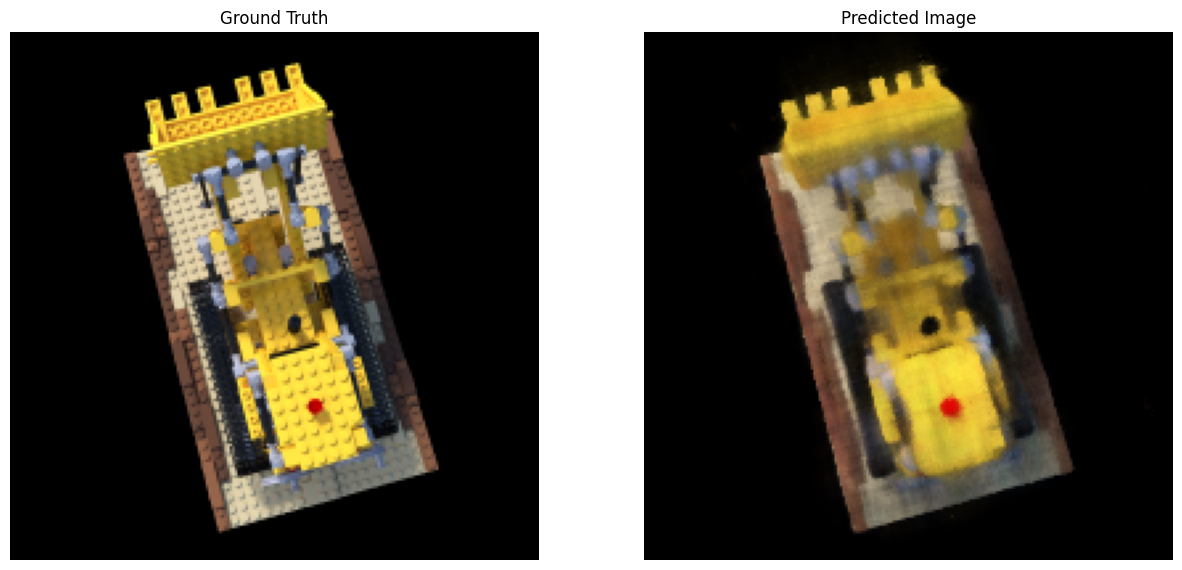

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(images_val[0])
ax[0].axis('off')
ax[0].set_title('Ground Truth')

ax[1].imshow(im.detach().cpu().numpy())
ax[1].axis('off')
ax[1].set_title('Predicted Image')

In [41]:
get_gif(model, c2ws_test, K, 'cpu', 'lego.gif')